In [1]:
import numpy as np 
import pandas as pd
import re 

from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
import spacy

import nltk
from nltk.stem.snowball import SnowballStemmer

In [3]:
WORK_DIR = Path.cwd()
DATA_DIR = Path.cwd()/'data'

## Data Cleaning and Preprocessing

In [4]:
train = pd.read_csv(DATA_DIR/'raw/train.csv')
test = pd.read_csv(DATA_DIR/'raw/test.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train = train.fillna('missing')
test = test.fillna('missing')
train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', ' ').lower())
test['keyword'] = test['keyword'].apply(lambda x: x.replace('%20', ' ').lower())

words = len([word for word in test.keyword.unique() if word not in train.keyword.unique()])
print(f'{words} Keywords in Test But not in Train')

0 Keywords in Test But not in Train


In [7]:
# Location is too fine-grained and maynot be useful 
train.location.fillna('missing').apply(lambda x: x.lower()).value_counts()

missing                  2533
usa                       104
new york                   75
united states              50
london                     49
                         ... 
sisterhood                  1
cimerak - pangandaran       1
ondo                        1
u.s                         1
the void, u.s.a             1
Name: location, Length: 3234, dtype: int64

In [8]:
# May need to stem some of these words eg. wounded/wounds
train.keyword.fillna('missing').value_counts().sort_index()

ablaze               36
accident             35
aftershock           34
airplane accident    35
ambulance            38
                     ..
wounded              37
wounds               33
wreck                37
wreckage             39
wrecked              39
Name: keyword, Length: 222, dtype: int64

<AxesSubplot:>

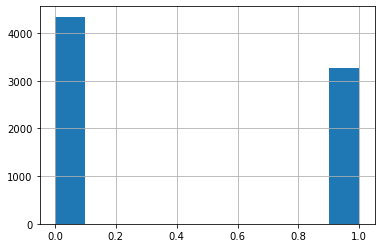

In [9]:
# So no imbalance class problem
train.target.hist()

In [10]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

def lemmatize_text(text): 
    return (' '.join([token.lemma_ for token in nlp(text.lower()) if (token.text not in stop_words) & (not token.is_punct)]).replace('# ', ''))

def extract_hashtag(tweet):
    split_tweet = tweet.split('#')
    if len(split_tweet)>1:
        hashtags = [hashtag.split()[0] for hashtag in split_tweet[1:] if len(hashtag)>=1]
        return ' '.join(sorted(hashtags))
    else:
        return 'missing'

In [11]:
# Lemmatize keywords
lemmatized_kw = [lemmatize_text(x) for x in train.keyword.unique()]
lemmatized_dict = dict(zip(train.keyword.unique(), lemmatized_kw))
train['keyword_processed'] = train.keyword.map(lemmatized_dict)
train['keyword_processed'] = train['keyword_processed'].apply(lambda x: ''.join(x.split(' ')))

test['keyword_processed'] = test.keyword.map(lemmatized_dict)
test['keyword_processed'] = test['keyword_processed'].apply(lambda x: ''.join(x.split(' ')))

## Lemmatize main body text
train['text_processed'] = train.text.apply(lambda x: lemmatize_text(x))
test['text_processed'] = test.text.apply(lambda x: lemmatize_text(x))

# Extracting Hashtags
train['hashtags'] = train.text.apply(lambda x: extract_hashtag(x))
test['hashtags'] = test.text.apply(lambda x: extract_hashtag(x))

# Using regex to clean up different links
train['text_processed'] = train.text_processed.apply(lambda x: re.sub('http://[aA-zZ0-9\/\.]+',  'http', x).replace('http http', 'http'))
test['text_processed'] = test.text_processed.apply(lambda x:  re.sub('http://[aA-zZ0-9\/\.]+',  'http', x).replace('http http', 'http'))

# Drop duplicates tweets for train test
train = train.drop_duplicates('text_processed').reset_index(drop=True)

In [12]:
train.loc[train.text_processed.str.contains('')]

,id,keyword,location,text,target,keyword_processed,text_processed,hashtags
0,1,missing,missing,Our Deeds are the Reason of this #earthquake M...,1,miss,deed reason earthquake allah forgive,earthquake
1,4,missing,missing,Forest fire near La Ronge Sask. Canada,1,miss,forest fire near la ronge sask canada,missing
2,5,missing,missing,All residents asked to 'shelter in place' are ...,1,miss,resident ask shelter place notify officer evac...,missing
3,6,missing,missing,"13,000 people receive #wildfires evacuation or...",1,miss,"13,000 people receive wildfire evacuation orde...",wildfires
4,7,missing,missing,Just got sent this photo from Ruby #Alaska as ...,1,miss,got send photo ruby alaska smoke wildfire pour...,Alaska wildfires
...,...,...,...,...,...,...,...,...
6970,10860,missing,missing,a siren just went off and it wasn't the Forney...,1,miss,siren go forney tornado warning,missing
6971,10862,missing,missing,Officials say a quarantine is in place at an A...,1,miss,official quarantine place alabama home possibl...,missing
6972,10863,missing,missing,#WorldNews Fallen powerlines on G:link tram: U...,1,miss,worldnews fall powerline g link tram update fi...,WorldNews
6973,10864,missing,missing,on the flip side I'm at Walmart and there is a...,1,miss,flip walmart bomb evacuate stay tune blow,missing


In [13]:
train.to_pickle(DATA_DIR/'interim/train.pkl')
test.to_pickle(DATA_DIR/'interim/test.pkl')

In [14]:
word_vector = np.array([token.vector for token in nlp(train.text_processed[0])]).shape

In [15]:
word_vector

(5, 96)

## EDA And Visualization

#### A1. Comparing Keywords Prevalence of Actual Disaster

In [16]:
kw_ohe = pd.get_dummies(train['keyword'],drop_first=True)
train_merged = train.merge(kw_ohe, left_index=True, right_index=True)

In [17]:
kw_val = train_merged.iloc[:, 8:].values
num_disaster = np.array([np.sum(train.target.values * kw_val[:, num]) for num in range(kw_val.shape[1])])

kw_count = train_merged.iloc[:, 8:].sum()
kw_proba = pd.Series(num_disaster/kw_count.values, index=kw_count.index)
kw_proba.sort_values()

body bag           0.000000
aftershock         0.000000
body bags          0.025000
ruin               0.027027
blazing            0.030303
                     ...   
suicide bomber     0.964286
suicide bombing    0.965517
wreckage           1.000000
debris             1.000000
derailment         1.000000
Length: 221, dtype: float64

In [18]:
# separating Keywords into either groups that has high probability with 0 or 1
low_kw = list(kw_proba.sort_values()[0:50].index)
high_kw = list(kw_proba.sort_values()[-50:].index)
main_kw = low_kw + high_kw
all_kw = kw_proba.index

#### A2. Body Text Prevalence of Actual Disaster

In [27]:
count = CountVectorizer(ngram_range=(1,1), min_df=20)

In [48]:
count = CountVectorizer(ngram_range=(2,2), min_df=20)

In [49]:
vectorized = count.fit_transform(train['text_processed'])
vector = pd.DataFrame(np.c_[vectorized.toarray(), np.array(train.target)], columns = count.get_feature_names()+['target'])

In [24]:
def calc_prevalence(df): 
    features = df.drop('target', axis=1)
    active = np.sum(np.array(features) * train.target.to_numpy().reshape(-1,1), axis=0)
    word_counts = np.sum(np.array(features), axis=0)
    series = pd.Series(active/word_counts, index=features.columns)
    return series.sort_values(ascending=False)


def export

In [47]:
prevalence = calc_prevalence(vector)

def 
list(prevalence.index[(prevalence>0.75)]) + list(prevalence.index[(prevalence<0.25)])

['mh370',
 'legionnaire',
 'mosque',
 'debris',
 'migrant',
 'derailment',
 'northern',
 'severe',
 'hiroshima',
 'bombing',
 'warning',
 'bomber',
 'typhoon',
 'spill',
 'saudi',
 'flooding',
 'wildfire',
 'reunion',
 'malaysia',
 'outbreak',
 'japan',
 'hundred',
 'reuter',
 'soudelor',
 'aircraft',
 'suspect',
 'helicopter',
 'atomic',
 'california',
 'suicide',
 '70',
 'anniversary',
 'east',
 'crew',
 'amid',
 'confirm',
 'island',
 'plane',
 'earthquake',
 'bridge',
 'calgary',
 'pakistan',
 'victim',
 'near',
 'kill',
 'rd',
 'mark',
 'airplane',
 'km',
 'rescuer',
 'west',
 'drought',
 'thunderstorm',
 'project',
 'train',
 'hailstorm',
 'terrorist',
 'officer',
 '40',
 'issue',
 'murder',
 'evacuation',
 'case',
 'massacre',
 'county',
 'india',
 'south',
 'area',
 'report',
 'north',
 'affect',
 'close',
 'obama',
 '05',
 'boat',
 'alarm',
 'million',
 'search',
 '08',
 'vehicle',
 'continue',
 '15',
 '06',
 'volcano',
 'forest',
 'displace',
 'weather',
 '00',
 'police',
 'o

In [50]:
train.loc[train.text_processed.str.contains('electrocute')].iloc[1]['text']

'Kids got Disney version of the game Operation only 2 AA batteries? I swear my old version had like 8 Ds and would nearly electrocute you.'

In [51]:
train.loc[train.text_processed.str.contains('pay pile')]

,id,keyword,location,text,target,keyword_processed,text_processed,hashtags
2116,3211,deluged,missing,susinesses are deluged with invoices. Make you...,0,deluge,susinesse deluge invoice stlnd colour shape li...,missing
2118,3216,deluged,missing,Businesses are deluged with invoices. Make you...,0,deluge,business deluge invoice stand colo r shape lzk...,missing
2120,3218,deluged,missing,Businesses are deluged with invoices. Make you...,0,deluge,business deluge invoice stand colour shape lik...,missing
2123,3222,deluged,missing,Businesses are deluged with invokces. Make you...,0,deluge,business deluge invokce stand colour shape.and...,missing
2128,3235,deluged,missing,Businesses are deluged with inroices.|Make you...,0,deluge,business deluge inroices.|make stand colour sh...,missing
2130,3237,deluged,missing,Businesses are deluged with invoices. Make you...,0,deluge,business deluge invoice stand oup colour shame...,missing
2131,3239,deluged,missing,Businesses are deluged with invzices. Make you...,0,deluge,business deluge invzice stand colour shape it'...,missing
2132,3240,deluged,missing,Businesses are deluged with invoices. Make you...,1,deluge,business deluge invoice stand colour shape lik...,missing
2135,3243,deluged,missing,Businesses are deluged with invoices. Make you...,0,deluge,business deluge invoice stand ogt colomr shape...,missing
2136,3244,deluged,missing,Businesses are|deluged with invoices. Make y u...,0,deluge,business are|deluge invoice y ur stand colour ...,missing


In [ ]:
y